# Building a ChatBot using LangGraph Part - I

- Simple bot with LLM
- Adding Tool
- Adding Memory
- Add Human In the Loop

## Simple Bot With LLM

### Installing Packages

In [ ]:
#!pip install -U langgraph langsmith

### Create a StateGraph

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
#from langsmith import traceable


1. StateGraph - It structures the chatbot as state machine. (messages is schema, and append to the list is done by reducer functions)
2. Nodes - Calling LLM/Function.
3. Edges - transistion between the functions.

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

1. Each Node receives the current state as input, and outputs an update to the state.
2. Updates to messages will be appended to the existing list.

### Add a node

In [ ]:
# !pip install -U "langchain[google-genai]"

In [3]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

llm = init_chat_model("google_genai:gemini-2.0-flash")

In [4]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

add_messages function in our state will append the LLM's response to messages list.

### Adding an Entry Point

It tells the graph where it should start its work each time it is run.

In [5]:
graph_builder.add_edge(START, 'chatbot')

### Adding an Exit Point

It indicates where the graph should finish execution.

In [6]:
graph_builder.add_edge('chatbot', END)

### Compile the Graph

In [7]:
simple_graph = graph_builder.compile()

### Visualize the graph

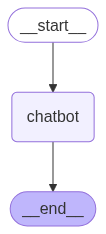

In [8]:
from IPython.display import Image, display

try:
    display(Image(simple_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Run the Bot

In [9]:

def stream_graph_updates(user_input: str):
    for event in simple_graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: OpenAI is an artificial intelligence research and deployment company dedicated to ensuring that general-purpose AI benefits all of humanity.
Goodbye!


### Chatbot with Tool

In [ ]:
#pip install -U langchain-tavily

In [10]:
import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

### Defining the tool

In [11]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=1)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://langchain-ai.github.io/langgraphjs/concepts/low_level/',
   'title': 'LangGraph Glossary',
   'content': 'In LangGraph, nodes are typically JavaScript/TypeScript functions (sync or async ) where the first positional argument is the state, and (optionally), the',
   'score': 0.9163571,
   'raw_content': None}],
 'response_time': 1.56,
 'request_id': 'c70a7ed6-ce4f-48a6-b05e-19fe0ec31f75'}

In [12]:
llm_with_tools = llm.bind_tools(tools)

def chatbot_with_tools(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot_with_tools", chatbot_with_tools)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


### Create a function to run the tools

In [13]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


### Adding Conditional Edges

Edges control the flow from one node to next.

In [14]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot_with_tools",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot_with_tools")
graph_builder.add_edge(START, "chatbot_with_tools")
graph_with_tools = graph_builder.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


### Visualize the graph

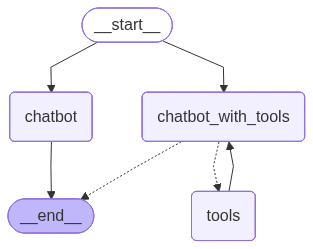

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph_with_tools.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Run the bot with tools

In [16]:
def stream_graph_updates(user_input: str):
    for event in graph_with_tools.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: As an AI, I do not have access to real-time information, including live stock prices. Stock prices change constantly throughout the day.

**To get the current stock price for Apple (AAPL), I recommend checking one of these sources:**

*   **A financial website:** such as Google Finance, Yahoo Finance, Bloomberg, or MarketWatch.
*   **Your brokerage account:** If you have a brokerage account, the current price will be displayed there.
*   **A reliable financial news app.**
Assistant: {"query": "apple stock price", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Financial Analysis for AAPL", "url": "https://finance.yahoo.com/quote/AAPL/", "content": "Stock: AAPL\nFinancial Analysis:\nLatest Open Price: 232.51 Latest Close Price: 232.14 Highest Close Price: 258.10 Lowest Close Price: 163.82 Average Close Price (2 years): 205.27 Standard Deviation of Close Price: 23.74 Volume Traded (2 years): 28565119600 Total Return (2 years): 24.9

Though the bot has access to tool for search, it cannot remember past interactions on its own, \
which limits its ability to have coherent, multi-turn conversations.